Dodawanie bibliotek.

---



In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

import random
seed_value = 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)


***Opis zmienych.***
1.   **BONUS** - klasa bonus malus (zakres 1-13, 1 max zwyżka, 3 podstawowa, 13 max zniżka).
2.   **WOJ** - województwo.
3.   **KL_SUB** - klasa sumy ubezpieczenia.
4.   **KL_WIEK** - klasa wieku klienta.
5.   **ZN_ROK** - procent zniżki za jednorazową opłatę składki (0 gdy płatna w ratach).
6.   **ZN_OC** - procent zniżki za OC w PZU (0 gdy brak OC).
7.   **PROC_SKL** - procent składki wg taryfy.
8.   **SUMA_UB** - suma ubezpieczenia (wartość pojazdu).
9.   **KWOTA** - kwota wypłaty związana z oszustwem.
10.  **PLEC** - Plec (M , K).
11.  **EXPO** - ryzyko przeszacowane (ekspozycja) (= długość polisy w roku 2015 * suma ubezp.).
12.  **R_PROD** - Rok produkcji pojazdu.
13.  **R_URO** - rok urodzenia posiadacza.
14.  **WIEK_POJ** - wiek pojazdu (w latach w roku 2015)
15.  **WIEK_POS** - wiek posiadacza (w roku 2015)
16.  **FRAUD** - *oszustwo (FRAUD=1) zawiera fraud techniczny. To jest nasz target.*
17.  **TECH** - flaga technicznej definicji fraudu (TECH=1) 



# **1. Przygotowanie danych**





In [68]:
df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/dataset/frauddatam/fraud_dm_edit.xlsx')
df.head()

,BONUS,WOJ,KL_SUB,KL_WIEK,ZN_ROK,ZN_OC,PROC_SKL,SUMA_UB,KWOTA,POJEM,PLEC,EXPO,R_PROD,R_URO,WIEK_POJ,WIEK_POS,FRAUD,TECH
0,13,3,2,3,5,15,12.12,1800.0,0.0,1400.0,M,1301.917808,2014.0,1967.0,5.0,52.0,0,0
1,5,3,2,3,0,15,12.12,1900.0,0.0,1997.0,M,1426.301370,2006.0,1972.0,13.0,47.0,0,0
2,13,3,3,4,5,15,12.12,3300.0,0.0,1389.0,M,2911.232877,2017.0,1964.0,2.0,55.0,1,1
3,13,3,2,4,0,15,12.12,1600.0,0.0,1100.0,M,1122.191781,2016.0,1958.0,3.0,61.0,0,0
4,13,3,2,3,5,15,12.12,1010.0,0.0,1500.0,M,794.164384,2014.0,1971.0,5.0,48.0,0,0


***Opis danych.***

In [69]:
df.describe()

,BONUS,WOJ,KL_SUB,KL_WIEK,ZN_ROK,ZN_OC,PROC_SKL,SUMA_UB,KWOTA,POJEM,EXPO,R_PROD,R_URO,WIEK_POJ,WIEK_POS,FRAUD,TECH
count,8914.000000,8914.000000,8914.000000,8914.000000,8914.000000,8914.000000,8914.000000,8914.000000,8914.000000,8811.000000,8914.000000,8877.000000,8895.000000,8877.000000,8895.000000,8914.000000,8914.000000
mean,8.813664,21.271932,1.834081,3.087839,3.508526,15.324770,10.012078,1710.772940,101.387618,1261.579276,964.768564,2013.699448,1971.706914,5.300552,47.293086,0.212923,0.198676
std,3.876784,13.021437,0.692607,0.847394,13.049096,38.608023,27.482417,2279.575572,1282.638912,473.041481,1836.529274,3.976045,12.306651,3.976045,12.306651,0.409397,0.399026
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.600000,25.000000,0.000000,80.000000,0.356164,1990.000000,1920.000000,0.000000,18.000000,0.000000,0.000000
25%,5.000000,14.000000,1.000000,3.000000,0.000000,15.000000,8.900000,800.000000,0.000000,796.000000,268.232877,2011.000000,1964.000000,2.000000,39.000000,0.000000,0.000000
50%,10.000000,16.000000,2.000000,3.000000,5.000000,15.000000,8.900000,1400.000000,0.000000,1332.000000,670.684932,2015.000000,1972.000000,4.000000,47.000000,0.000000,0.000000
75%,13.000000,32.000000,2.000000,4.000000,5.000000,15.000000,10.100000,2300.000000,0.000000,1593.000000,1323.287671,2017.000000,1980.000000,8.000000,55.000000,0.000000,0.000000
max,13.000000,49.000000,5.000000,5.000000,1215.000000,3645.000000,2595.240000,170100.000000,65000.000000,6823.000000,142604.383560,2019.000000,2001.000000,29.000000,99.000000,1.000000,1.000000


***Wykres liczby obiektów tupy NaN.***


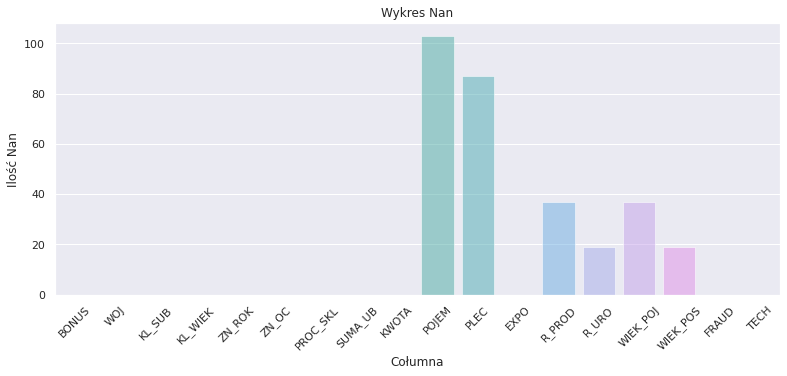

In [70]:
carrier_count = df.isnull().sum()
_, ax = plt.subplots(figsize=(13,5))
sns.set(style="darkgrid")
p = sns.barplot(carrier_count.index, carrier_count.values, alpha=0.5, ax=ax)
p.set_xticklabels(p.get_xticklabels(), rotation=45)
plt.title('Wykres Nan')
plt.ylabel('Ilość Nan', fontsize=12)
plt.xlabel('Cołumna', fontsize=12)
plt.show()

***Macierze korelacji***


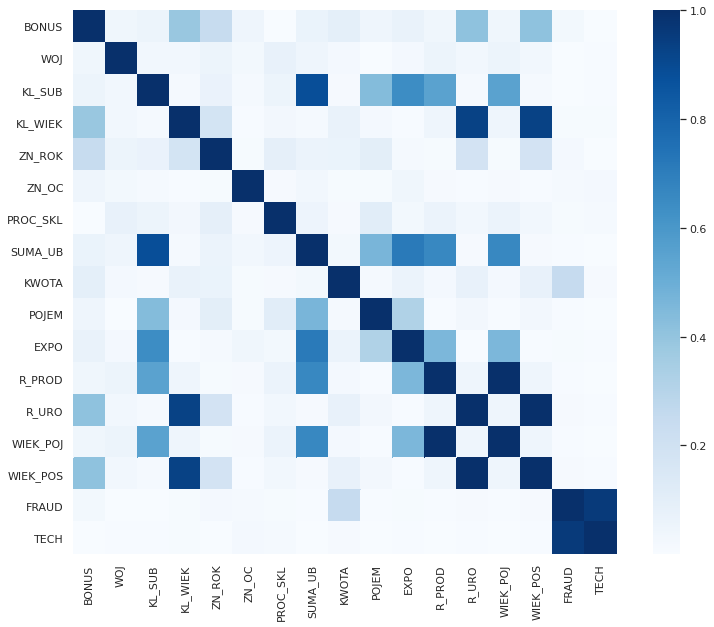

['SUMA_UB', 'R_URO', 'WIEK_POJ', 'WIEK_POS', 'TECH']

In [71]:
correlation_matrix = df.corr(method = "spearman").abs()

fig = plt.figure(figsize=(13,10))
sns.heatmap(correlation_matrix, cmap='Blues', square=True)
plt.show()

upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k = 1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
to_drop

Wyrzucamy zmiene o wysokiej korelacji wyższej niż 0.9

In [72]:
df_without_corr9 = df.drop(to_drop, axis=1)
df_without_corr9.head()

,BONUS,WOJ,KL_SUB,KL_WIEK,ZN_ROK,ZN_OC,PROC_SKL,KWOTA,POJEM,PLEC,EXPO,R_PROD,FRAUD
0,13,3,2,3,5,15,12.12,0.0,1400.0,M,1301.917808,2014.0,0
1,5,3,2,3,0,15,12.12,0.0,1997.0,M,1426.301370,2006.0,0
2,13,3,3,4,5,15,12.12,0.0,1389.0,M,2911.232877,2017.0,1
3,13,3,2,4,0,15,12.12,0.0,1100.0,M,1122.191781,2016.0,0
4,13,3,2,3,5,15,12.12,0.0,1500.0,M,794.164384,2014.0,0


Zastąpienie danych kategoryjnych danymi nominalnymi w PLEC

In [73]:
df_without_corr9['PLEC'] = pd.factorize(df_without_corr9['PLEC'])[0]
df_without_corr9.PLEC.value_counts()

 0    6835
 1    1992
-1      87
Name: PLEC, dtype: int64

Usuwanie Nan w nominalnych danych. Stosując metodę MICE.

In [0]:
from fancyimpute import IterativeImputer as MICE
df_without_nan = pd.DataFrame(MICE().fit_transform(df_without_corr9))

In [0]:
df_without_nan.isnull().sum().sum()
df_without_nan.columns = df_without_corr9.columns

***Transformacja danych***

In [76]:
df_without_nan.describe()

,BONUS,WOJ,KL_SUB,KL_WIEK,ZN_ROK,ZN_OC,PROC_SKL,KWOTA,POJEM,PLEC,EXPO,R_PROD,FRAUD
count,8914.000000,8914.000000,8914.000000,8914.000000,8914.000000,8914.000000,8914.000000,8914.000000,8914.000000,8914.000000,8914.000000,8914.000000,8914.000000
mean,8.813664,21.271932,1.834081,3.087839,3.508526,15.324770,10.012078,101.387618,1260.772413,0.213709,964.768564,2013.696048,0.212923
std,3.876784,13.021437,0.692607,0.847394,13.049096,38.608023,27.482417,1282.638912,472.296687,0.433103,1836.529274,3.970294,0.409397
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.600000,0.000000,80.000000,-1.000000,0.356164,1990.000000,0.000000
25%,5.000000,14.000000,1.000000,3.000000,0.000000,15.000000,8.900000,0.000000,796.000000,0.000000,268.232877,2011.000000,0.000000
50%,10.000000,16.000000,2.000000,3.000000,5.000000,15.000000,8.900000,0.000000,1300.000000,0.000000,670.684932,2015.000000,0.000000
75%,13.000000,32.000000,2.000000,4.000000,5.000000,15.000000,10.100000,0.000000,1590.000000,0.000000,1323.287671,2017.000000,0.000000
max,13.000000,49.000000,5.000000,5.000000,1215.000000,3645.000000,2595.240000,65000.000000,6823.000000,1.000000,142604.383560,2019.000000,1.000000


Używam do przetworzenia danych MinMaxScaler.

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = pd.DataFrame(scaler.fit_transform(df_without_nan)) 
scaled_data.columns = df_without_corr9.columns

Używam do przetworzenia danych StandartScaler

In [78]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
temp = df_without_nan.drop(['FRAUD'], axis=1)
scaled_data = pd.DataFrame(scaler.fit_transform(temp))
scaled_data['FRAUD'] = df_without_corr9.FRAUD
scaled_data.columns = df_without_corr9.columns
scaled_data.describe()

,BONUS,WOJ,KL_SUB,KL_WIEK,ZN_ROK,ZN_OC,PROC_SKL,KWOTA,POJEM,PLEC,EXPO,R_PROD,FRAUD
count,8.914000e+03,8.914000e+03,8.914000e+03,8.914000e+03,8.914000e+03,8.914000e+03,8.914000e+03,8.914000e+03,8.914000e+03,8.914000e+03,8.914000e+03,8.914000e+03,8914.000000
mean,-5.101122e-16,-4.511087e-15,-8.141158e-16,-4.456336e-16,-2.897833e-16,-6.467849e-16,-1.346841e-15,-1.328426e-14,-3.205872e-17,1.044586e-16,-2.366417e-18,-5.372634e-14,0.212923
std,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,0.409397
min,-2.015615e+00,-1.556900e+00,-1.204331e+00,-2.463973e+00,-2.688863e-01,-3.969545e-01,-2.333287e-01,-7.905055e-02,-2.500205e+00,-2.802513e+00,-5.251572e-01,-5.968671e+00,0.000000
25%,-9.837737e-01,-5.584898e-01,-1.204331e+00,-1.036640e-01,-2.688863e-01,-8.412455e-03,-4.046733e-02,-7.905055e-02,-9.841240e-01,-4.934640e-01,-3.792887e-01,-6.790931e-01,0.000000
50%,3.060276e-01,-4.048883e-01,2.395703e-01,-1.036640e-01,1.143035e-01,-8.412455e-03,-4.046733e-02,-7.905055e-02,8.306175e-02,-4.934640e-01,-1.601391e-01,3.284456e-01,0.000000
75%,1.079908e+00,8.239237e-01,2.395703e-01,1.076490e+00,1.143035e-01,-8.412455e-03,3.199402e-03,-7.905055e-02,6.971170e-01,-4.934640e-01,1.952265e-01,8.322149e-01,0.000000
max,1.079908e+00,2.129536e+00,4.571274e+00,2.256645e+00,9.284624e+01,9.401877e+01,9.407371e+01,5.060056e+01,1.177764e+01,1.815585e+00,7.712785e+01,1.335984e+00,1.000000


Podzielenie zbioru danych na dwie części Train/Test 0.8/0.2 od zbioru.


In [0]:
from sklearn.model_selection import train_test_split

X = scaled_data.drop(['FRAUD'], axis=1)
y = scaled_data.FRAUD

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

2. Budowa modeli Klasyfikacyjnych ( DT, ANN )

# 2. **Budowa modeli klasyfikacyjnych**

2A: Jako benchmark **LDA(Latent Dirichlet Allocation)**

In [0]:
from sklearn.externals import joblib 
def plot_roc_cur(fper, tper, score):  
    plt.plot(fper, tper, color='orange', label='ROC AUC: '+ str(score))
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend()

In [81]:
model_lda = LDA( solver='svd')
model_lda.fit(X_train, y_train)
model_lda.score(X_test, y_test)

0.7908020190689848

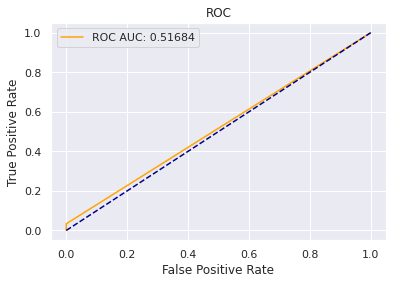

In [82]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

y_pred = model_lda.predict(X_test)
y_pred = ( y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)

roc_auc = round(roc_auc_score(y_test, y_pred), 5)
fper, tper, thresholds = roc_curve(y_test, y_pred)
plot_roc_cur(fper, tper, roc_auc) 

2B. **DT( Decision Tree Classifier )**

GridSearchCV - funkcja, która wybiera najlepsze hiperparametry z względu na roc_auc

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

parameters = {'max_depth' : range(1,15), 
              'min_samples_split' : [0.005, 0.01, 0.05, 0.10],
              'criterion' : ["gini", "entropy"]}
              
m_dtree = DecisionTreeClassifier(random_state=11)

model_DT = GridSearchCV(m_dtree, parameters, scoring="roc_auc")
model_DT.fit(X_train, y_train)

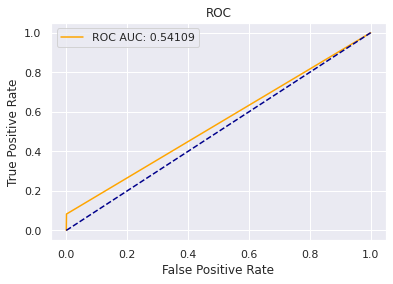

In [84]:
y_pred = model_DT.predict(X_test)
y_pred = ( y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)

roc_auc = round(roc_auc_score(y_test, y_pred), 5)
fper, tper, thresholds = roc_curve(y_test, y_pred)
plot_roc_cur(fper, tper, roc_auc) 


2D. **XGBOOST**

In [0]:
from xgboost import XGBClassifier
model_boost = XGBClassifier()
parameters = {
  'max_depth':[4,5,6],
  'min_child_weight':[4,5,6],
  'min_child_weight':[6,8,10,12],
}

model_XGBOOST = GridSearchCV(model_boost, parameters, scoring="roc_auc")
model_XGBOOST.fit(X_train, y_train)

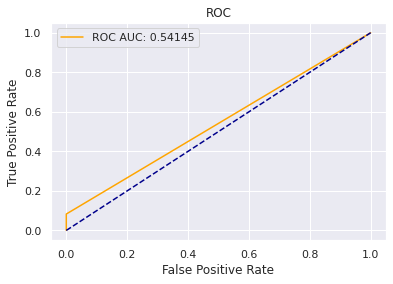

In [100]:
y_pred = model_XGBOOST.predict(X_test)
y_pred = ( y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)

roc_auc = round(roc_auc_score(y_test, y_pred), 5)
fper, tper, thresholds = roc_curve(y_test, y_pred)
plot_roc_cur(fper, tper, roc_auc) 


2D. **Random Forest Classifier**

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

parameters = { 'max_depth' : range(5,15),
               'bootstrap': [True, False],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1],
               'min_samples_split': [2, 5],
               'n_estimators': [200]}

model_randomforest = RandomForestClassifier(random_state = 11)

model_RF = GridSearchCV(model_randomforest, parameters, scoring="roc_auc")
model_RF.fit(X_train, y_train)

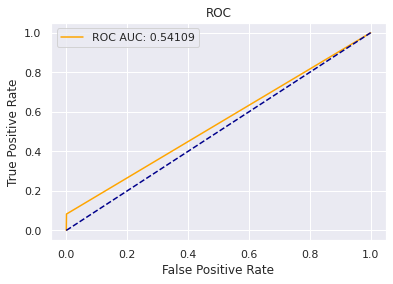

In [88]:
y_pred = model_RF.predict(X_test)
y_pred = ( y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)

roc_auc = round(roc_auc_score(y_test, y_pred), 5)
fper, tper, thresholds = roc_curve(y_test, y_pred)
plot_roc_cur(fper, tper, roc_auc) 

2D. **BaggingClassifier**

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier

parameters = {}
m_bagging = BaggingClassifier(random_state = 11)

model_BAGGING = GridSearchCV(m_bagging, parameters, scoring="roc_auc")
model_BAGGING.fit(X_train, y_train)

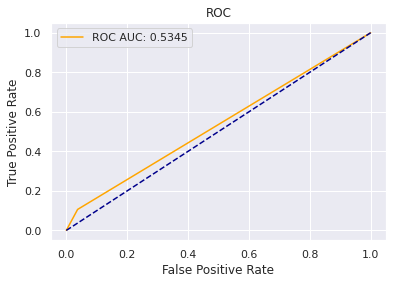

In [90]:
y_pred = model_BAGGING.predict(X_test)
y_pred = ( y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)


roc_auc = round(roc_auc_score(y_test, y_pred), 5)
fper, tper, thresholds = roc_curve(y_test, y_pred)
plot_roc_cur(fper, tper, roc_auc) 

# 3. **Porównanie wybranych modeli**

In [0]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
def auc_datum(model, X_test):
  y_pred_model = model.predict(X_test)
  y_pred_model = ( y_pred_model > 0.01)
  cm_model = confusion_matrix(y_test, y_pred_model)

  roc_auc_model = round(roc_auc_score(y_test, y_pred_model), 5)
  fper_model, tper_model, _ = roc_curve(y_test, y_pred_model)

  return fper_model, tper_model, roc_auc_model

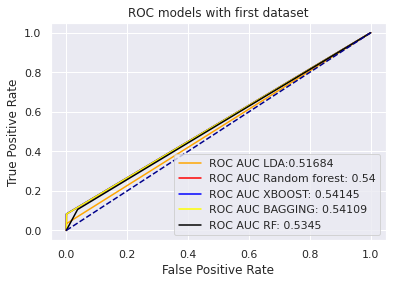

In [112]:
score_lda = auc_datum(model_lda, X_test)
score_DT = auc_datum(model_DT, X_test)
score_boost = auc_datum(model_XGBOOST, X_test)
score_RF = auc_datum(model_RF, X_test)
score_BAGGING = auc_datum(model_BAGGING, X_test)

plt.plot(score_lda[0], score_lda[1], color='orange', label='ROC AUC LDA:'+ str(score_lda[2]))
plt.plot(score_rf[0], score_rf[1], color='red', label='ROC AUC Random forest: '+ str(score_rf[2]))
plt.plot(score_boost[0], score_boost[1], color='blue', label='ROC AUC XBOOST: '+ str(score_boost[2]))
plt.plot(score_RF[0], score_RF[1], color='yellow', label='ROC AUC BAGGING: '+ str(score_RF[2]))
plt.plot(score_BAGGING[0], score_BAGGING[1], color='black', label='ROC AUC RF: '+ str(score_BAGGING[2]))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC models with first dataset')
plt.legend()

#4. **Dyskusja**

In [115]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
#Fit the model
y_pred_model = model_XGBOOST.predict(X_test)
y_pred_model = ( y_pred_model > 0.01)
#Generate predictions with the model using our X values
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model)
print(cf_matrix)

[[1397    0]
 [ 354   32]]


Najlepszy model XBOOST

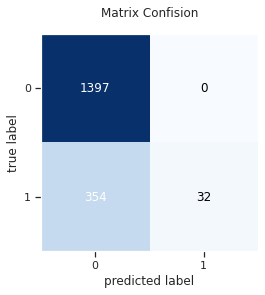

In [124]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plot_confusion_matrix(conf_mat=cf_matrix)
plt.title("Matrix Confision")
plt.show()

Do porównania, wybrałem metrykę AUC score który dobrze nadaje się do oceny modeli klasyfikacyjnych. Wyniki pokazują, że najlepszy model do klasyfikacji tych dannych jest XBOOST. Jeśli chodzi o sam model to AUC 0.54 сałkiem słaby wynik. Może to wynikać z braku odpowiednich danych. 

Accuracy tego modelu równa się 0.8, co jest całkiem niezłe.
Można budować Сonfusion matrix aby zatwierdzić wyniki.
Confusion Matrix pokazuje, że istnieje wiele elementów false negative 354 są dobrу prognozy, tyłko 32. To tylko potwierdza, że nasz model jest zły w klasyfikowaniu klas. Potwierdza fakt, że lepiej nie używać metryki jak accuracy do celów klasyfikacji ponieważ wyniki mogą być błędnie zinterpretowane.


